#Project 1: Part 1 - Linear Regression Using Gradient Descent
- Train a Recurrent Neural Network Model model on the time series dataset.
  - Implement the model from scratch (Recurrent Neural Network Model)
  - Pre-Processing of the dataset (COVID dataset used - https://www.kaggle.com/datasets/niketchauhan/covid-19-time-series-data, Population dataset used: 2020 population column from https://www.kaggle.com/datasets/rsrishav/world-population)
  - Tune parameters such as learning rate, epochs etc. to achieve the optimum error value.
  - Measure the model using Sum Square Error evaluation statistics.

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
get_ipython().run_line_magic('pylab', 'inline')
import math
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# import data
df_covid = pd.read_csv('COVID_Data.csv')
df_population = pd.read_csv('2021_population_updated.csv')

In [ ]:
print(df_covid.columns)
print(df_population.columns)

Index(['Country/Region', 'Lat', 'Long', 'Dates', 'Confirmed Cases',
       'Death Cases', 'Recovered Cases'],
      dtype='object')
Index(['iso_code', 'country', '2021_last_updated', '2020_population', 'area',
       'density_sq_km', 'growth_rate', 'world_%', 'rank', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')


In [ ]:
# Update name 'US' to 'United States'
df_covid.loc[df_covid['Country/Region'] == 'US', 'Country/Region'] = 'United States'

print(df_covid[['Country/Region', 'Dates', 'Lat' ,'Long']].drop_duplicates().shape)
print(df_covid[['Country/Region', 'Dates']].drop_duplicates().shape)

(75294, 4)
(53580, 2)


We see same country present more than once on the same date due to latitude and longitude. Grouping the numbers on country

In [ ]:
# Dataset has multiple cases for the same country, same date on different latitude, longitudes. Grouping them on country, date
df_covid = df_covid.groupby(['Country/Region', 'Dates'], as_index=False).agg({'Confirmed Cases': 'sum', 'Death Cases': 'sum', 'Recovered Cases': 'sum'})
df_covid.rename({'Country/Region': 'country', 'Confirmed Cases': 'confirmed', 'Death Cases': 'deaths', 'Recovered Cases': 'recovered', 'Dates': 'dates'}, axis=1, inplace=True)

In [ ]:
covid_data = df_population[['country','2020_population', 'area', 'growth_rate']].merge(df_covid, on='country', how='inner')
covid_data['dates'] = pd.to_datetime(covid_data['dates'], format='%d-%m-%Y')

In [ ]:
covid_data.dtypes

country                    object
2020_population             int64
area                        int64
growth_rate               float64
dates              datetime64[ns]
confirmed                   int64
deaths                      int64
recovered                 float64
dtype: object

In [ ]:
# Group data to get daywise confirmed cases for all countries. Create column to calculate percentage of covid cases by population
world=covid_data.groupby("country", as_index= False).agg({"confirmed": 'max', "deaths": 'max', "recovered": 'max', '2020_population': 'max'})
world['covid%'] = world['confirmed']/world['2020_population']

In [ ]:
world.describe()

,confirmed,deaths,recovered,2020_population,covid%
count,1.680000e+02,168.000000,1.680000e+02,1.680000e+02,168.000000
mean,2.645923e+05,6985.803571,3.387760e+06,4.446381e+07,0.007905
std,1.033680e+06,25129.017500,1.850209e+06,1.582826e+08,0.010271
min,2.000000e+00,0.000000,7.089000e+05,3.393100e+04,0.000003
25%,4.086250e+03,61.750000,2.156598e+06,2.941138e+06,0.000586
50%,2.856850e+04,321.500000,3.141688e+06,1.000194e+07,0.004211
75%,1.161172e+05,2011.750000,4.508739e+06,3.153308e+07,0.010920
max,8.944934e+06,228656.000000,9.279912e+06,1.439324e+09,0.059108


In [ ]:
world[world['recovered'] > world['confirmed']].shape

(164, 6)

In all of the countries, number of recovered cases have been shown more than the confirmed cases and due to this, recoveries column will be removed from data analysis and modelling part.

In [ ]:
# Plot of Deaths
figure=px.choropleth(world,locations="country",locationmode="country names",color="deaths",hover_name="country"
                ,range_color=[1,100000],color_continuous_scale="reds",title="Contries with Deaths")
figure.show()

# Plot of Confirmed cases
figure=px.choropleth(world,locations="country",locationmode="country names",color="confirmed",hover_name="country"
                ,range_color=[1,4000000],color_continuous_scale="greens",title="Contries with Active Cases")
figure.show()

# Plot of % Confirmed cases by population
figure=px.choropleth(world,locations="country",locationmode="country names",color="covid%",hover_name="country"
                ,range_color=[0,0.03],color_continuous_scale="blues",title="%Confirmed Cases by Population")
figure.show()

In [ ]:
# check for NULLs in data
covid_data.isnull().sum(axis=0)

country            0
2020_population    0
area               0
growth_rate        0
dates              0
confirmed          0
deaths             0
recovered          0
dtype: int64

In [ ]:
# transform date to datetime format
covid_data['delete'] = 1
dates = covid_data[['dates', 'delete']].drop_duplicates().set_index('dates').resample('D').asfreq().index
countries = covid_data['country'].unique()
idx = pd.MultiIndex.from_product((dates, countries), names=['dates', 'country'])
covid_data.drop('delete', axis=1, inplace = True)
covid_data.set_index(['dates', 'country']).reindex(idx, fill_value=0).reset_index()

covid_data.update(covid_data.groupby('country')['confirmed', 'deaths'].ffill().fillna(0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



[Text(0, 0.5, 'Total cases'), Text(0.5, 0, 'dates')]

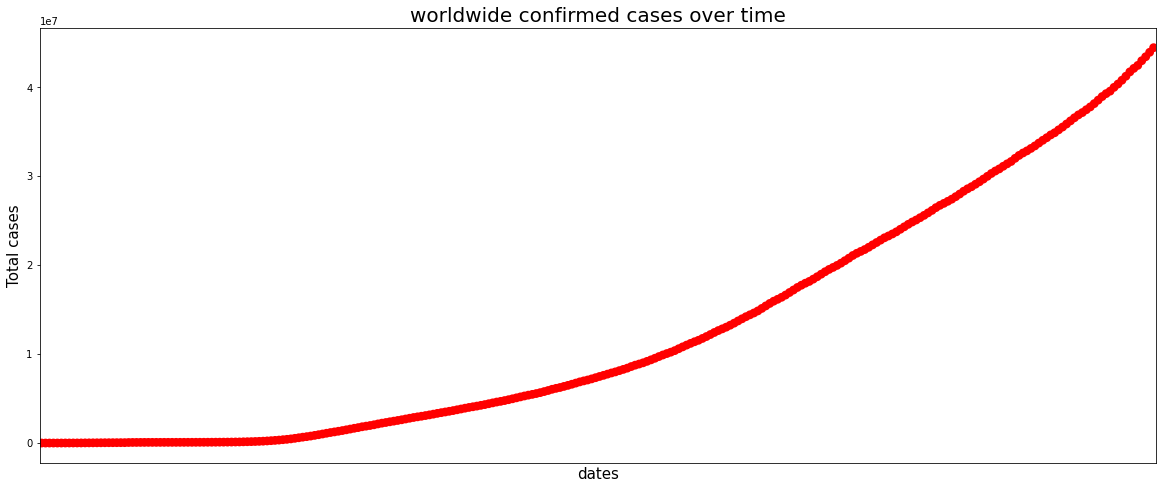

In [ ]:
# plot of confirmed cases worldwide with time.
cases=covid_data.groupby("dates", as_index=False).agg({"confirmed": 'sum', 'deaths': 'sum'})
plt.figure(figsize=(20,8))
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel("Dates",fontsize=15)
plt.ylabel("total cases",fontsize=15)
plt.title("worldwide confirmed cases over time",fontsize=20)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax=sns.pointplot(x=cases['dates'],y=cases['confirmed'],color="r")
ax.set(xlabel="dates",ylabel="Total cases")

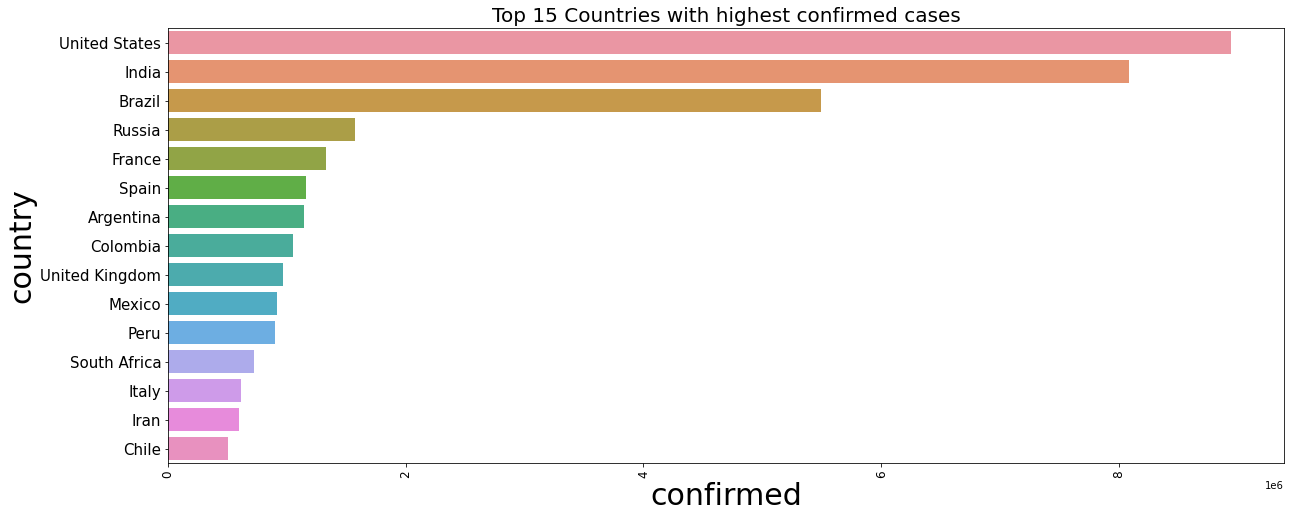

In [ ]:
# plot of top 15 countries with high confirmed cases at the end of 2020.
confirmed_by_country=covid_data.groupby("country", as_index = False).agg({"confirmed": 'max'}).sort_values(by='confirmed',ascending=False).head(15)
plt.figure(figsize=(20,8))
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel("active",fontsize=30)
plt.ylabel("country",fontsize=30)
plt.title("Top 15 Countries with highest confirmed cases",fontsize=20)

ax=sns.barplot(x=confirmed_by_country.confirmed,y=confirmed_by_country.country)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

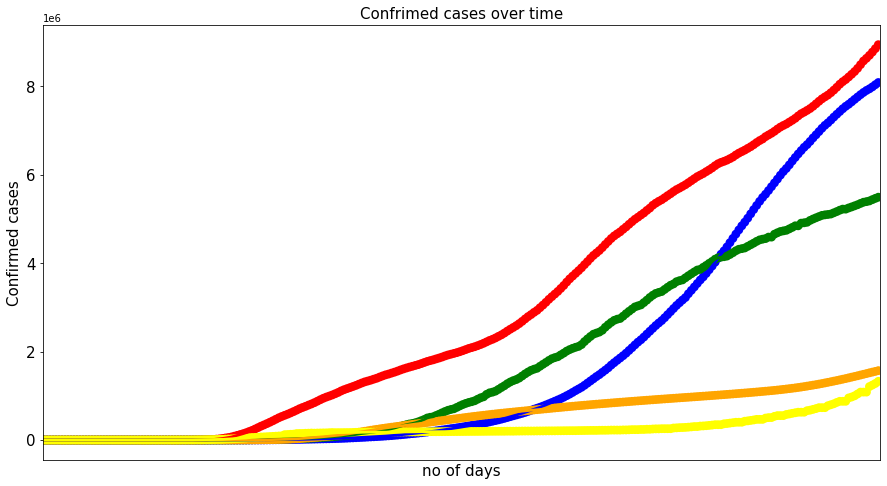

In [ ]:
# trend of top 5 countries with high confirmed cases for the year 2020.
plt.figure(figsize=(15,8))

countries = ['United States', 'India', 'Brazil', 'Russia', 'France']
colors = ['red', 'blue', 'green', 'orange', 'yellow']

for i in range(5):
  df_ = covid_data[covid_data['country']==countries[i]].groupby('dates', as_index=False).agg({"confirmed": 'sum', 'deaths': 'sum'})
  sns.pointplot(df_['dates'],df_['confirmed'],color=colors[i])
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel("no of days",fontsize=15)
plt.ylabel("Confirmed cases",fontsize=15)
plt.title("Confrimed cases over time",fontsize=15)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

In [ ]:
# Get the worldwide data for building the model
world_covid_data = covid_data.groupby(['dates']).agg({'confirmed': 'sum'})

# Preprocessing and Model

In [ ]:
# Function for scaling
def scale(df, flag=False):
  scale = MinMaxScaler().fit_transform(pd.DataFrame(df['confirmed']))
  return pd.DataFrame(scale, columns = ['confirmed'])

In [ ]:
# function to do train test split
def getTrainTestData(df, seq_len = 10, col = 'confirmed'):
  num_records = df.shape[0]-50
  x_train = []
  y_train = []
  x_val = []
  y_val = []

  for i in range(num_records - seq_len):
      x_train.append(df[col][i:i+seq_len])
      y_train.append(df[col][i+seq_len])
  x_train = np.array(x_train)
  x_train = np.expand_dims(x_train, axis=2)
  y_train = np.array(y_train)
  y_train = np.expand_dims(y_train, axis=1)

  for i in range(num_records -50 - seq_len, num_records - seq_len):
    x_val.append(df[col][i:i+seq_len])
    y_val.append(df[col][i+seq_len])
  x_val = np.array(x_val)
  x_val = np.expand_dims(x_val, axis=2)
  y_val = np.array(y_val)
  y_val = np.expand_dims(y_val, axis=1)

  return x_train, y_train, x_val, y_val

In [ ]:
# sigmoid function
def sigmoid(val):
    return 1 / (1 + np.exp(-val))

In [ ]:
# function to calculate error for generated predicted value
def getError(x_data,y_data,wt, dim_hidden, sequence_length):
    loss = 0.0
    for i in range(y_data.shape[0]):
        x, y = x_data[i], y_data[i]
        prev_state = np.zeros((dim_hidden, 1))
        for s in range(sequence_length):
            get_input = np.zeros(x.shape)
            get_input[s] = x[s]
            mul_wt1 = np.dot(wt[0], get_input)
            mul_wt2 = np.dot(wt[1], prev_state)
            prev_state = sigmoid(mul_wt1 + mul_wt2)
            mul_wt3 = np.dot(wt[2], prev_state)
        loss += (y - mul_wt3)**2 / 2
    return loss,y

In [ ]:
# function to train RNN model
def train(x_train,y_train,x_val,y_val,lr,epochs,sequence_length,dim_hidden,dim_output,truncate,min_limit,max_limit):
    np.random.seed(1200)
    wt = []
    wt.append(np.random.uniform(0, 1, (dim_hidden, sequence_length)))
    wt.append(np.random.uniform(0, 1, (dim_hidden, dim_hidden)))
    wt.append(np.random.uniform(0, 1, (dim_output, dim_hidden)))
    for epoch in range(epochs):
        train_loss,y = getError(x_train,y_train,wt, dim_hidden, sequence_length)
        train_loss = train_loss / float(y.shape[0])

        val_loss,y = getError(x_val,y_val,wt, dim_hidden, sequence_length)
        val_loss = val_loss / float(y.shape[0])
        print('Epoch: ', epoch + 1, ', Training Loss: ', train_loss, ', Validation Loss: ', val_loss)
        for i in range(y_train.shape[0]):
            x, y = x_train[i], y_train[i]
            layers = []
            prev_state = np.zeros((dim_hidden, 1))
            delta_wt = []
            delta_wt_t = []
            delta_wt_i = []
            for i in range(3):
              delta_wt.append(np.zeros(wt[i].shape))
              delta_wt_t.append(np.zeros(wt[i].shape))
              if(i==2): break
              delta_wt_i.append(np.zeros(wt[i].shape))

            for s in range(sequence_length):
                get_input = np.zeros(x.shape)
                get_input[s] = x[s]
                mul_wt1 = np.dot(wt[0], get_input)
                mul_wt2 = np.dot(wt[1], prev_state)
                add = mul_wt1 + mul_wt2
                mul_wt3 = np.dot(wt[2], sigmoid(add))
                layers.append({'current_state':sigmoid(add), 'previous_state':prev_state})
                prev_state = sigmoid(add)

            mul_wt3_d = (mul_wt3 - y)
            for s in range(sequence_length):
                delta_wt_t[2] = np.dot(mul_wt3_d, np.transpose(layers[s]['current_state']))
                mul_wt2_d = add * (1 - add) * np.dot(np.transpose(wt[2]), mul_wt3_d) * np.ones_like(mul_wt2)
                prev_state_d = np.dot(np.transpose(wt[1]), mul_wt2_d)
                for i in range(s-1, max(-1, s-truncate-1), -1):
                    mul_wt2_d = add * (1 - add) * (np.dot(np.transpose(wt[2]), mul_wt3_d) + prev_state_d) * np.ones_like(mul_wt2)
                    mul_wt1_d = add * (1 - add) * (np.dot(np.transpose(wt[2]), mul_wt3_d) + prev_state_d) * np.ones_like(mul_wt1)
                    delta_wt_i[1] = np.dot(wt[1], layers[s]['previous_state'])
                    prev_state_d = np.dot(np.transpose(wt[1]), mul_wt2_d)

                    get_input = np.zeros(x.shape)
                    get_input[s] = x[s]
                    delta_wt_i[0] = np.dot(wt[0], get_input)
                    dx = np.dot(np.transpose(wt[0]), mul_wt1_d)

                    delta_wt_t[0] += delta_wt_i[0]
                    delta_wt_t[1] += delta_wt_i[1]

                for i in range(3):
                    delta_wt[i] += delta_wt_t[i]
                for i in range(3):
                    if delta_wt[i].max() > max_limit:
                        delta_wt[i][delta_wt[i] > max_limit] = max_limit
                    if delta_wt[i].min() < min_limit:
                        delta_wt[i][delta_wt[i] < min_limit] = min_limit

            for i in range(3):
                wt[i] -= lr * delta_wt[i]

    return wt

In [ ]:
def predict(x_data, y_data, dim_hidden, wt, sequence_length):
    preds = []
    for i in range(y_data.shape[0]):
        x, y = x_data[i], y_data[i]
        prev_state = np.zeros((dim_hidden, 1))
        for t in range(sequence_length):
            mul_wt1 = np.dot(wt[0], x)
            mul_wt2 = np.dot(wt[1], prev_state)
            prev_state = sigmoid(mul_wt1 + mul_wt2)
            mul_wt3 = np.dot(wt[2], prev_state)
        preds.append(mul_wt3)
    return preds

In [ ]:
learning_rate = 0.0001
epochs = 24
sequence_length = 8
dim_hidden = 512
dim_output = 1
truncate = 8
min_limit = -5
max_limit = 5

In [ ]:
scale_data = scale(world_covid_data)
x_train, y_train, x_val, y_val = getTrainTestData(scale_data, sequence_length)
weights = train(x_train, y_train, x_val, y_val,learning_rate, epochs,sequence_length,dim_hidden,dim_output,truncate,min_limit,max_limit)

Epoch:  1 , Training Loss:  [[8085141.30296195]] , Validation Loss:  [[1800678.48606954]]
Epoch:  2 , Training Loss:  [[5002230.25735588]] , Validation Loss:  [[1113391.40408945]]
Epoch:  3 , Training Loss:  [[2655906.10301371]] , Validation Loss:  [[590521.03890933]]
Epoch:  4 , Training Loss:  [[1046168.83993547]] , Validation Loss:  [[232067.39052919]]
Epoch:  5 , Training Loss:  [[173013.42532171]] , Validation Loss:  [[38029.35305511]]
Epoch:  6 , Training Loss:  [[1030.4119707]] , Validation Loss:  [[186.36896559]]
Epoch:  7 , Training Loss:  [[917.40565993]] , Validation Loss:  [[315.08017312]]
Epoch:  8 , Training Loss:  [[280.89510937]] , Validation Loss:  [[22.82667655]]
Epoch:  9 , Training Loss:  [[270.59276352]] , Validation Loss:  [[51.20436827]]
Epoch:  10 , Training Loss:  [[356.6838]] , Validation Loss:  [[45.78282773]]
Epoch:  11 , Training Loss:  [[96.81633458]] , Validation Loss:  [[34.72491081]]
Epoch:  12 , Training Loss:  [[29.21185173]] , Validation Loss:  [[14.

In [ ]:
predictions = np.array(predict(x_train, y_train, 128, weights, sequence_length))
plt.plot(predictions[:, 0, 0]-0.24, 'g')
plt.plot(y_train[:, 0], 'r')
plt.show()

ValueError: ignored

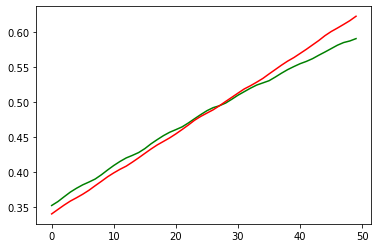

In [ ]:
predictions = np.array(predict(x_val, y_val, 128, weights, sequence_length))
plt.plot(predictions[:, 0, 0]-0.24, 'g')
plt.plot(y_val[:, 0], 'r')
plt.show()